In [92]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from typing import Dict, List, Any
from math import inf

In [93]:
climate_df: pd.DataFrame = pd.read_csv("../data/Cleaned_Data_Seasonal.csv")
# climate_df = climate_df[climate_df["Region"].isin(["CWP", "SWP", "CEA", "SEA", "SPL"])]
climate_df.head()

,Region,Year,Season,ACI_Combined_Seasonal_Smoothed,ACI_Combined_Seasonal_Unsmoothed,CDD_Seasonal_Smoothed,CDD_Seasonal_Unsmoothed,CDD_Seasonal_Unsmoothed_Unstandardized,Rx5Day_Seasonal_Smoothed,Rx5Day_Seasonal_Unsmoothed,...,Sea_Level_Seasonal_Unsmoothed_Unstandardized,T10_Seasonal_Smoothed,T10_Seasonal_Unsmoothed,T10_Seasonal_Unsmoothed_Unstandardized,T90_Seasonal_Smoothed,T90_Seasonal_Unsmoothed,T90_Seasonal_Unsmoothed_Unstandardized,WP90_Seasonal_Smoothed,WP90_Seasonal_Unsmoothed,WP90_Seasonal_Unsmoothed_Unstandardized
0,ALA,1961,1,0.24,0.58,0.13,-0.26,33.96,0.01,-0.57,...,7266.74,0.05,-1.51,1.31,-0.11,0.42,13.04,0.14,0.62,11.51
1,CAR,1961,1,-0.12,0.32,NaN,NaN,NaN,0.08,0.87,...,NaN,0.10,-0.98,5.47,-0.30,-0.12,10.12,-0.18,-0.47,8.62
2,CEA,1961,1,-0.31,-0.80,-0.18,-1.01,14.93,-0.17,-0.33,...,6917.55,0.09,1.19,15.88,-0.10,-0.41,8.26,-0.44,-1.05,7.18
3,CWP,1961,1,0.06,0.33,0.44,0.75,50.62,-0.49,-0.82,...,7126.53,-0.27,-1.29,2.70,0.06,0.79,13.28,-0.10,-0.27,9.00
4,MID,1961,1,0.05,-0.25,0.76,-0.47,22.53,-0.14,-1.01,...,NaN,-0.15,-0.65,6.86,-0.15,0.49,11.98,-0.34,-0.92,7.69


In [94]:
print(f"Records before dropping empty rows: {len(climate_df)}")
climate_df = climate_df.dropna()
print(f"Records after dropping empty rows: {len(climate_df)}")

Records before dropping empty rows: 4250
Records after dropping empty rows: 3250


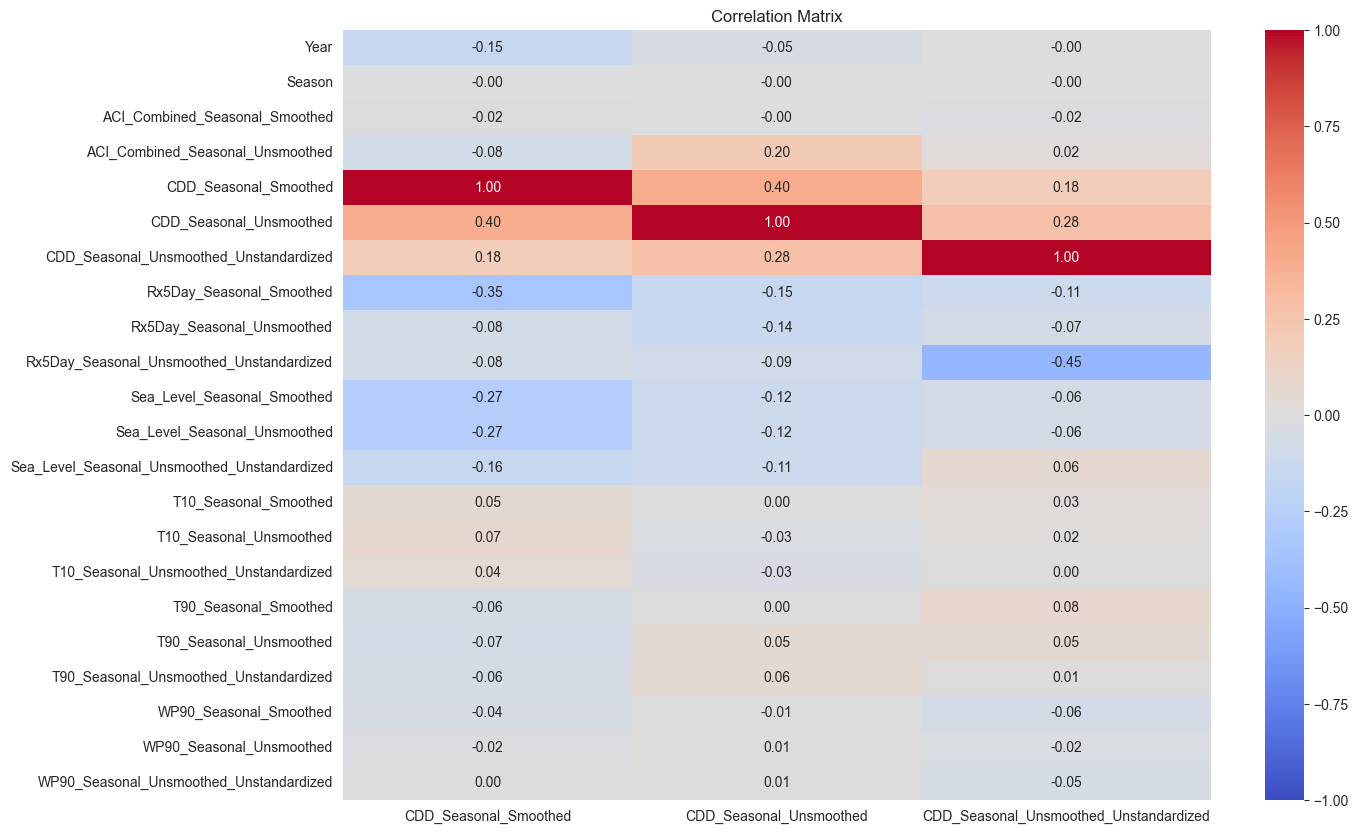

In [95]:
correlation_matrix = climate_df.corr(numeric_only=True)[["CDD_Seasonal_Smoothed", "CDD_Seasonal_Unsmoothed", "CDD_Seasonal_Unsmoothed_Unstandardized"]]
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [96]:
def build_linear_regression_model(feature_df: pd.DataFrame, target_df: pd.Series):
    x_train, x_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=0.3, random_state=1)
    x_train_const: pd.DataFrame = sm.add_constant(x_train)
    return sm.OLS(y_train, x_train_const.astype(float)).fit(), x_test, y_test

In [97]:
season_dummies: pd.DataFrame = pd.get_dummies(climate_df["Season"], prefix="Season")
region_dummies = pd.get_dummies(climate_df["Region"], prefix="Region")
time_features: pd.DataFrame = pd.concat([climate_df[["Year"]], season_dummies, region_dummies], axis=1)
target: pd.Series = climate_df["CDD_Seasonal_Smoothed"]

model, x_test, y_test = build_linear_regression_model(time_features, target)
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     CDD_Seasonal_Smoothed   R-squared:                       0.100
Model:                               OLS   Adj. R-squared:                  0.093
Method:                    Least Squares   F-statistic:                     15.65
Date:                   Sun, 18 Feb 2024   Prob (F-statistic):           1.40e-41
Time:                           14:57:07   Log-Likelihood:                -2080.7
No. Observations:                   2275   AIC:                             4195.
Df Residuals:                       2258   BIC:                             4293.
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2174 

In [98]:
def run_prediction(predictive_model, x_test_df: pd.DataFrame, y_test_df: pd.DataFrame):
    x_test_const: pd.DataFrame = sm.add_constant(x_test_df)
    y_prediction = predictive_model.predict(x_test_const)
    mse = mean_squared_error(y_test_df, y_prediction)
    r_squared = r2_score(y_test_df, y_prediction)
    
    print(f"The test data MSE is {round(mse, 3)}.")
    print(f"The test data r-squared value is {round(r_squared, 3)}.")
    return y_prediction

In [99]:
y_predictions = run_prediction(model, x_test, y_test)

The test data MSE is 0.369.
The test data r-squared value is 0.04.


In [100]:
def plot_actual_vs_predicted(actuals, predictions):
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.title('Actual vs. Predicted CDD Values')
    plt.xlabel('Actual CDD')
    plt.ylabel('Predicted CDD')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2) 
    plt.grid(True)
    plt.show()

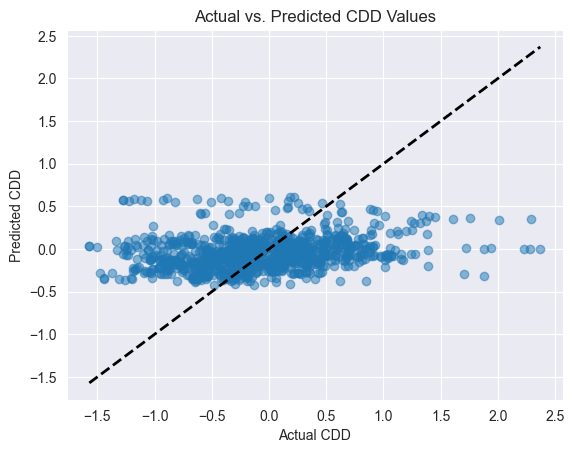

In [101]:
plot_actual_vs_predicted(y_test, y_predictions)

In [102]:
sea_level_time_features: pd.DataFrame = pd.concat([time_features, climate_df[["Sea_Level_Seasonal_Smoothed"]]], axis=1)

model, x_test, y_test = build_linear_regression_model(sea_level_time_features, target)
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     CDD_Seasonal_Smoothed   R-squared:                       0.139
Model:                               OLS   Adj. R-squared:                  0.133
Method:                    Least Squares   F-statistic:                     21.51
Date:                   Sun, 18 Feb 2024   Prob (F-statistic):           5.92e-62
Time:                           14:57:07   Log-Likelihood:                -2029.5
No. Observations:                   2275   AIC:                             4095.
Df Residuals:                       2257   BIC:                             4198.
Df Model:                             17                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [103]:
y_predictions = run_prediction(model, x_test, y_test)

The test data MSE is 0.356.
The test data r-squared value is 0.076.


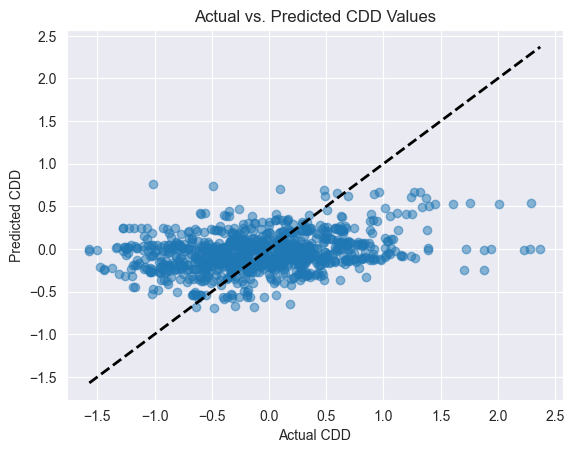

In [104]:
plot_actual_vs_predicted(y_test, y_predictions)

In [105]:
def generate_hyperparameters(params: Dict[str, List[Any]]) -> List[Dict[str, Any]]:
    keys = list(params.keys())
    values_product = product(*params.values())
    combinations = [{keys[i]: value for i, value in enumerate(values)} for values in values_product]
    return combinations

def find_optimal_hyperparameters(model_class, hyperparameters: List[Dict[str, Any]], features_df, target_series) -> Dict[str, Any]:
    x_train, x_test, y_train, y_test = train_test_split(features_df, target_series, test_size=0.3, random_state=1)
    
    min_mse = inf
    best_hyperparameters = None
    for hyperparameterSet in hyperparameters:
        model_instance = model_class(**hyperparameterSet, random_state=1)
        model_instance.fit(x_train, y_train)
        model_y_prediction = model_instance.predict(x_test)
        model_mse = mean_squared_error(y_test, model_y_prediction)
        
        if model_mse < min_mse:
            min_mse = model_mse
            best_hyperparameters = hyperparameterSet
            
    return best_hyperparameters

In [106]:
optimized_hyperparameters = find_optimal_hyperparameters(DecisionTreeRegressor, generate_hyperparameters({"max_depth": list(range(1, 21))}), sea_level_time_features, target)
print(f"The optimized hyperparameters are: {optimized_hyperparameters}")

The optimized hyperparameters are: {'max_depth': 19}


In [107]:
x_train, x_test, y_train, y_test = train_test_split(time_features, target, test_size=0.3, random_state=1)
dt_regressor = DecisionTreeRegressor(**optimized_hyperparameters, random_state=1)
dt_regressor.fit(x_train, y_train)

y_predictions = dt_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_predictions)
r_squared = r2_score(y_test, y_predictions)

print(f"The test data MSE is {round(mse, 3)}.")
print(f"The test data r-squared value is {round(r_squared, 3)}.\n")

The test data MSE is 0.025.
The test data r-squared value is 0.936.


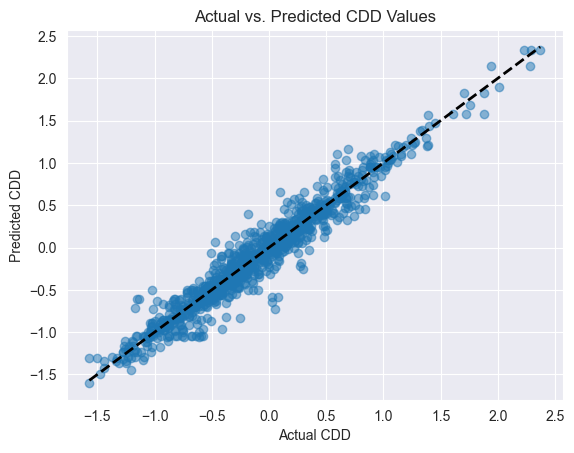

In [108]:
plot_actual_vs_predicted(y_test, y_predictions)

In [109]:
optimized_hyperparameters = find_optimal_hyperparameters(RandomForestRegressor, generate_hyperparameters({"max_depth": list(range(1, 21)), "n_estimators": range(10, 151, 10)}), sea_level_time_features, target)
print(f"The optimized hyperparameters are: {optimized_hyperparameters}")

The optimized hyperparameters are: {'max_depth': 19, 'n_estimators': 100}


In [110]:
x_train, x_test, y_train, y_test = train_test_split(time_features, target, test_size=0.3, random_state=1)
rf_regressor = RandomForestRegressor(**optimized_hyperparameters, random_state=1)
rf_regressor.fit(x_train, y_train)

y_predictions = rf_regressor.predict(x_test)
mse = mean_squared_error(y_test, y_predictions)
r_squared = r2_score(y_test, y_predictions)

print(f"The test data MSE is {round(mse, 3)}.")
print(f"The test data r-squared value is {round(r_squared, 3)}.\n")

The test data MSE is 0.014.
The test data r-squared value is 0.964.


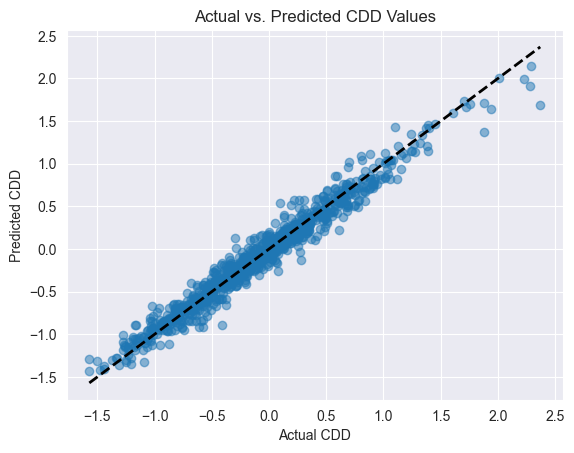

In [111]:
plot_actual_vs_predicted(y_test, y_predictions)